In [1]:
#importing the necessary libraries

import os
import cv2
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.client import device_lib
from keras.models import Model
from keras import layers, models
from keras.mixed_precision import set_global_policy
from keras.backend import clear_session
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import json
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import gc
from keras.backend import clear_session

In [2]:
#Organizing Pathes

# Define paths
base_dir = Path.cwd().parent
dataset_dir = base_dir / "data\\facescrub"
results_dir = base_dir / "results\\facescrub"

os.makedirs(results_dir, exist_ok=True)

In [3]:
# Function to load and preprocess images
def preprocess_facescrub(dataset_dir, img_size):
    image_paths = []
    labels = []
    label_to_index = {}
    current_label_index = 0

    # Read images and labels
    for label_name in tqdm(sorted(os.listdir(dataset_dir)), desc="Processing labels", unit="label"):
        label_dir = dataset_dir / label_name
        if os.path.isdir(label_dir):
            if label_name not in label_to_index:
                label_to_index[label_name] = current_label_index
                current_label_index += 1

            for image_name in os.listdir(label_dir):
                image_path = label_dir / image_name
                if image_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    image_paths.append(image_path)
                    labels.append(label_to_index[label_name])

    # Load, resize, and normalize images
    images = []
    for path in tqdm(image_paths, desc="Processing images", unit="image"):
        try:
            img = tf.keras.preprocessing.image.load_img(path, target_size=img_size, color_mode="grayscale")
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    print(f"Loaded {len(images)} images")
    print(f"Found {len(label_to_index)} labels")

    # Convert to numpy arrays
    print('converting to numpy arrays...')
    images = np.array(images, dtype="float32")/255.0 # Normalize to [0, 1]


    # Compute mean and std across the entire dataset
    # print('standardizing images...')
    # mean = np.mean(images, axis=(0, 1, 2), keepdims=True)  # Per-channel mean
    # std = np.std(images, axis=(0, 1, 2), keepdims=True)    # Per-channel std
    # # Standardize the images
    # s_images = (images - mean) / std
    
    # Split into train, validation, and test sets
    print("Splitting dataset...")
    # X_s_train, X_s_temp, y_s_train, y_s_temp = train_test_split(s_images, labels, test_size=0.3, stratify=labels, random_state=42)
    # X_s_val, X_s_test, y_s_val, y_s_test = train_test_split(X_s_temp, y_s_temp, test_size=0.5, stratify=y_s_temp, random_state=42)
    # X_s_train, X_s_val, X_s_test = np.array(X_s_train), np.array(X_s_val), np.array(X_s_test)

    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, label_to_index


In [4]:
# Preprocessing parameters
size = 45
IMG_SIZE = (size, size)  # Resize dimensions

# Preprocess the dataset
print("Preprocessing dataset...")
X_train, X_val, X_test, y_train, y_val, y_test, label_to_index = preprocess_facescrub(dataset_dir, img_size=IMG_SIZE)

# Save label-to-index mapping
print("Saving label-to-index mapping...")
with open(results_dir / "label_to_index.json", "w") as f:
    json.dump(label_to_index, f)

# Save datasets
print('saving data...')
np.save(results_dir / f"X{size}_gray_train.npy", X_train)
np.save(results_dir / f"X{size}_gray_val.npy", X_val)
np.save(results_dir / f"X{size}_gray_test.npy", X_test)
np.save(results_dir / "y_gray_train.npy", y_train)
np.save(results_dir / "y_gray_val.npy", y_val)
np.save(results_dir / "y_gray_test.npy", y_test)

print(f"Preprocessing complete! Saved preprocessed data to {results_dir}")

Preprocessing dataset...


Processing labels:   0%|          | 0/530 [00:00<?, ?label/s]

Processing images: 100%|██████████| 43124/43124 [07:43<00:00, 92.94image/s] 


Loaded 43124 images
Found 530 labels
converting to numpy arrays...
Splitting dataset...
Saving label-to-index mapping...
saving data...
Preprocessing complete! Saved preprocessed data to d:\CI\milestone_2\results\facescrub


In [5]:
# Enable GPU memory growth before any TensorFlow operation
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Error enabling memory growth: {e}")
else:
    print("No GPU detected.")

GPU memory growth enabled.


In [6]:
# Load preprocessed data
size = 45
X_train = np.load(results_dir / f"X{size}_train.npy", allow_pickle=True)
X_val = np.load(results_dir / f"X{size}_val.npy", allow_pickle=True)
X_test = np.load(results_dir / f"X{size}_test.npy", allow_pickle=True)
y_train = np.load(results_dir / "y_train.npy", allow_pickle=True)
y_val = np.load(results_dir / "y_val.npy", allow_pickle=True)
y_test = np.load(results_dir / "y_test.npy", allow_pickle=True)


# Verify shapes
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

Training set: (30186, 45, 45, 3), Labels: (30186,)
Validation set: (6469, 45, 45, 3), Labels: (6469,)
Test set: (6469, 45, 45, 3), Labels: (6469,)


In [22]:
# Define the Autoencoder model

# Optionally, force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Define the Autoencoder model
def build_autoencoder(input_shape, activation):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(input_layer)
    x = tf.keras.layers.Dense(1024, activation=activation)(x)
    x = tf.keras.layers.Dense(512, activation=activation)(x)
    bottleneck = tf.keras.layers.Dense(256, activation=activation)(x)
    x = tf.keras.layers.Dense(512, activation=activation)(bottleneck)
    x = tf.keras.layers.Dense(1024, activation=activation)(x)
    x = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
    output_layer = tf.keras.layers.Reshape(input_shape)(x)
    return tf.keras.models.Model(input_layer, output_layer)

# Build and compile the model
input_shape = X_train.shape[1:]
autoencoder = build_autoencoder(input_shape, activation='relu')
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # Optionally add metrics

# Display the model summary
autoencoder.summary()


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45, 45, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 6075)              0         
                                                                 
 dense (Dense)               (None, 1024)              6221824   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                            

Epoch 1/100
30/30 [==============================] - 5s 112ms/step - loss: 0.8872 - accuracy: 0.4672 - val_loss: 0.7096 - val_accuracy: 0.5289
Epoch 2/100
30/30 [==============================] - 3s 88ms/step - loss: 0.6721 - accuracy: 0.5502 - val_loss: 0.6404 - val_accuracy: 0.5597
Epoch 3/100
30/30 [==============================] - 3s 86ms/step - loss: 0.6186 - accuracy: 0.5674 - val_loss: 0.6065 - val_accuracy: 0.5678
Epoch 4/100
30/30 [==============================] - 3s 88ms/step - loss: 0.5917 - accuracy: 0.5758 - val_loss: 0.5870 - val_accuracy: 0.5784
Epoch 5/100
30/30 [==============================] - 3s 88ms/step - loss: 0.5768 - accuracy: 0.5897 - val_loss: 0.5728 - val_accuracy: 0.6080
Epoch 6/100
30/30 [==============================] - 3s 87ms/step - loss: 0.5598 - accuracy: 0.6357 - val_loss: 0.5546 - val_accuracy: 0.6466
Epoch 7/100
30/30 [==============================] - 3s 87ms/step - loss: 0.5413 - accuracy: 0.6553 - val_loss: 0.5371 - val_accuracy: 0.6597
Epoch

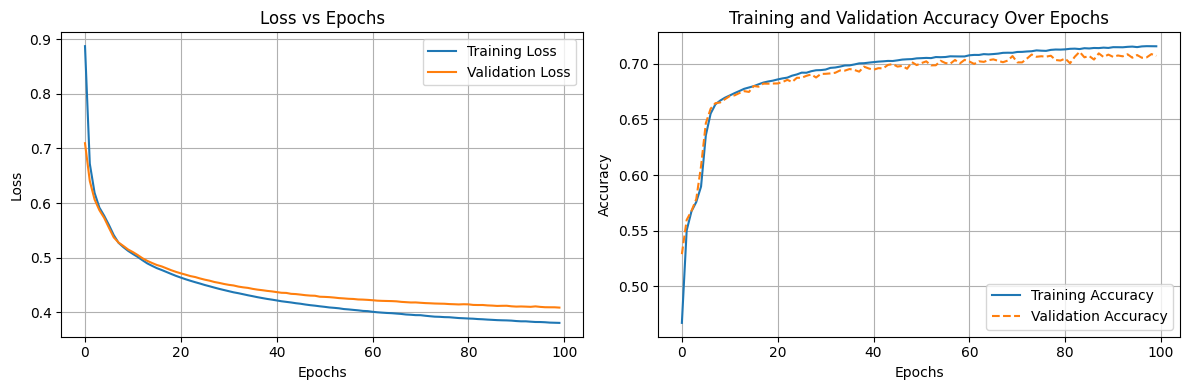

In [10]:
# Train the model
history = autoencoder.fit(
    X_s_train, X_s_train,
    validation_data=(X_s_val, X_s_val),
    epochs=100,
    batch_size=1024  # Use a smaller batch size to avoid memory issues
)

# Save the trained model
autoencoder.save(os.path.join(results_dir, "facescrub\\with_standard_vanilla_autoencoder.h5"))

# Plot training loss
plt.figure(figsize=(12, 4))

# Plot Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Epoch 1/100
30/30 [==============================] - 6s 171ms/step - loss: 0.0461 - accuracy: 0.8736 - val_loss: 0.0375 - val_accuracy: 0.9336
Epoch 2/100
30/30 [==============================] - 4s 148ms/step - loss: 0.0341 - accuracy: 0.9350 - val_loss: 0.0313 - val_accuracy: 0.9375
Epoch 3/100
30/30 [==============================] - 4s 147ms/step - loss: 0.0303 - accuracy: 0.9361 - val_loss: 0.0281 - val_accuracy: 0.9372
Epoch 4/100
30/30 [==============================] - 4s 150ms/step - loss: 0.0277 - accuracy: 0.9331 - val_loss: 0.0255 - val_accuracy: 0.9311
Epoch 5/100
30/30 [==============================] - 4s 150ms/step - loss: 0.0246 - accuracy: 0.9271 - val_loss: 0.0235 - val_accuracy: 0.9308
Epoch 6/100
30/30 [==============================] - 4s 150ms/step - loss: 0.0228 - accuracy: 0.9234 - val_loss: 0.0235 - val_accuracy: 0.9133
Epoch 7/100
30/30 [==============================] - 4s 149ms/step - loss: 0.0220 - accuracy: 0.9226 - val_loss: 0.0209 - val_accuracy: 0.9179

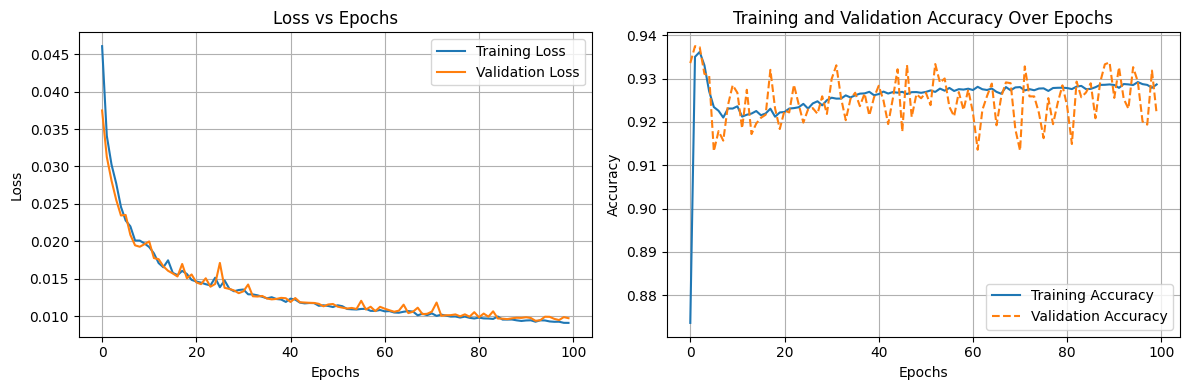

In [23]:
# Train the model without standardization
# Train autoencoder with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100,
    batch_size=1024,
    callbacks=[early_stopping]
)

# Save the trained model
autoencoder.save(os.path.join(results_dir, "vanilla_autoencoder.h5"))


# Plot training loss
plt.figure(figsize=(12, 4))

# Plot Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Clear memory
clear_session()  # Clear Keras session
gc.collect()     # Run garbage collection
del history  # Delete the model object to free memory


Loading model...
Testing the model...
203/203 [==============================] - 1s 5ms/step
Test Loss (MSE): 0.011648395


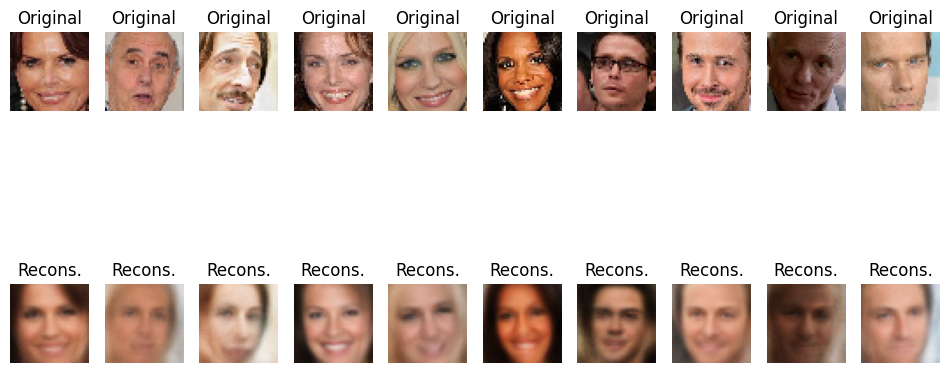

In [8]:
# Define the path to the saved model
#model_path = os.path.join(results_dir, "vanilla_autoencoder.h5")

# Load the model
print("Loading model...")
#autoencoder = load_model(model_path)

# Test the model
print("Testing the model...")
reconstructed_images = autoencoder.predict(X_test)

# Compute MSE
test_loss = np.mean(np.square(X_test - reconstructed_images), axis=(1, 2, 3))  # MSE for each sample
print("Test Loss (MSE):", np.mean(test_loss))

# Visualize some reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Recons.")
    plt.axis("off")
plt.show()

In [9]:
# Print all layer names to identify the correct one
for layer in autoencoder.layers:
    print(layer.name)


input_1
flatten
dense
dense_1
dense_2
dense_3
dense_4
dense_5
dense_6
dense_7
reshape


In [24]:
# Extract the encoder from the autoencoder
encoder = models.Model(autoencoder.input, autoencoder.get_layer('dense_3').output)  # Adjust the layer name as per your model

In [25]:
# Extract features from the encoder
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)
scaler = StandardScaler()
encoded_train = scaler.fit_transform(encoded_train)
encoded_test = scaler.transform(encoded_test)

203/203 [==============================] - 1s 2ms/step


In [26]:
# Train SVM classifier
classifier = SVC(kernel='linear')
print("Training SVM Classifier...")
classifier.fit(encoded_train, y_train)

# Predict and evaluate
print("Predicting...")
y_pred = classifier.predict(encoded_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Classifier Accuracy:", accuracy*100, "%")


Training SVM Classifier...
Predicting...
SVM Classifier Accuracy: 29.108053795022414 %


In [9]:
# Cross Validation
# Store results for plotting
loss_curve = {"configurations": [], "training_loss": [], "validation_loss": []}

# Define the grid search space
layer_options = [2, 3, 4]  # Number of hidden layers
node_options = [256, 512, 1024]  # Nodes per layer
#latent_dim = 128  # Fixed bottleneck size

# Store results
results = []

# Define the autoencoder builder for different configurations
def build_custom_autoencoder(input_shape, num_layers, num_nodes, activation='relu'):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(input_layer)
    for _ in range(num_layers):
        x = tf.keras.layers.Dense(num_nodes, activation=activation)(x)
        num_nodes = num_nodes // 2  # Halve the number of nodes for the next layer
    x = tf.keras.layers.Dense(num_nodes // 2, activation=activation)(x)
    for _ in range(num_layers):
        num_nodes = num_nodes * 2  # Halve the number of nodes for the next layer
        x = tf.keras.layers.Dense(num_nodes, activation=activation)(x)
    x = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
    output_layer = tf.keras.layers.Reshape(input_shape)(x)
    return tf.keras.models.Model(input_layer, output_layer)
# Grid search loop
for num_layers in layer_options:
    for num_nodes in node_options:
        print(f"Testing configuration: {num_layers} layers, {num_nodes} nodes")
        
        # Build and compile autoencoder
        autoencoder = build_custom_autoencoder(X_train.shape[1:], num_layers, num_nodes)
        autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

        # Train autoencoder with early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = autoencoder.fit(
            X_train, X_train,
            validation_data=(X_val, X_val),
            epochs=30,
            batch_size=1024,
            callbacks=[early_stopping],
            verbose=0
        )

        # Store training and validation loss for the final epoch
        final_training_loss = history.history['loss'][-1]
        final_validation_loss = history.history['val_loss'][-1]
        
        # Record results for plotting
        config_name = f"{num_layers} layers, {num_nodes} nodes"
        loss_curve["configurations"].append(config_name)
        loss_curve["training_loss"].append(final_training_loss)
        loss_curve["validation_loss"].append(final_validation_loss)

        print(f"  Training Loss: {final_training_loss:.6f}")
        print(f"  Validation Loss: {final_validation_loss:.6f}")
        # Clear memory
        clear_session()  # Clear Keras session
        gc.collect()     # Run garbage collection
        del autoencoder  # Delete the model object to free memory


Testing configuration: 2 layers, 256 nodes
  Training Loss: 0.015588
  Validation Loss: 0.015172
Testing configuration: 2 layers, 512 nodes
  Training Loss: 0.014439
  Validation Loss: 0.014133
Testing configuration: 2 layers, 1024 nodes
  Training Loss: 0.013010
  Validation Loss: 0.012866
Testing configuration: 3 layers, 256 nodes
  Training Loss: 0.017331
  Validation Loss: 0.017204
Testing configuration: 3 layers, 512 nodes
  Training Loss: 0.015928
  Validation Loss: 0.015564
Testing configuration: 3 layers, 1024 nodes
  Training Loss: 0.015202
  Validation Loss: 0.015367
Testing configuration: 4 layers, 256 nodes
  Training Loss: 0.021644
  Validation Loss: 0.021627
Testing configuration: 4 layers, 512 nodes
  Training Loss: 0.019212
  Validation Loss: 0.019093
Testing configuration: 4 layers, 1024 nodes
  Training Loss: 0.017603
  Validation Loss: 0.017454


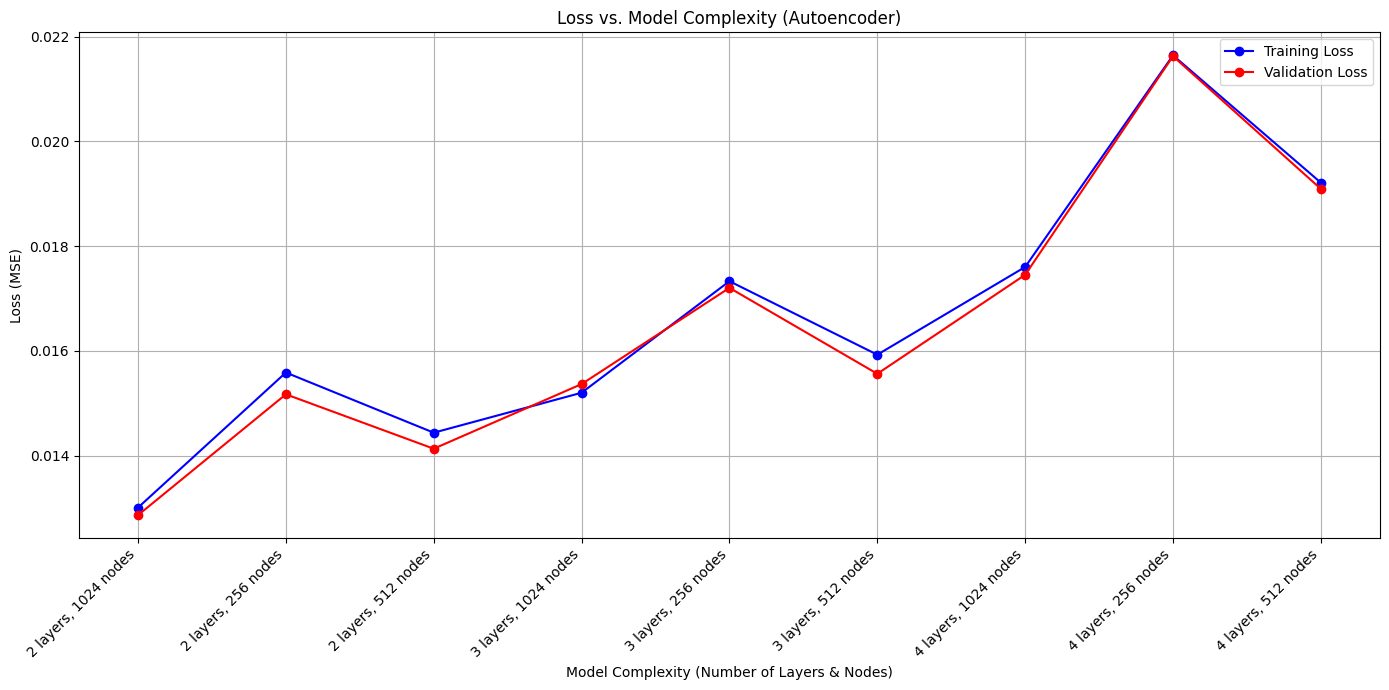

In [10]:
# Convert loss_curve to a DataFrame for easier visualization
loss_df = pd.DataFrame(loss_curve)

# Plot Training and Validation Loss vs. Model Complexity
plt.figure(figsize=(14, 7))

# Sort configurations by increasing complexity
sorted_idx = np.argsort(loss_df["configurations"])
sorted_configs = np.array(loss_df["configurations"])[sorted_idx]

# Plot training loss
plt.plot(
    sorted_configs,
    np.array(loss_df["training_loss"])[sorted_idx],
    marker='o',
    label='Training Loss',
    color='blue'
)

# Plot validation loss
plt.plot(
    sorted_configs,
    np.array(loss_df["validation_loss"])[sorted_idx],
    marker='o',
    label='Validation Loss',
    color='red'
)

plt.title("Loss vs. Model Complexity (Autoencoder)")
plt.xlabel("Model Complexity (Number of Layers & Nodes)")
plt.ylabel("Loss (MSE)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
